In [1]:
#BERT: BI-Directional Encoder Representation from Transformers
# importing the data and important librares
import torch 

In [2]:
print(torch.__version__)

2.9.0


In [3]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification,TrainingArguments,Trainer
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [4]:
import pandas as pd
import numpy as np

In [5]:
sms = pd.read_csv("sms.csv")

In [6]:
# data cleaning

In [7]:
sms.head()

,spam/not spam,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
sms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   spam/not spam  5572 non-null   object
 1   Text           5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [9]:
#If their will be any no value column , we would have dropped them

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
sms.isnull().sum() # no column like that so we don't do anything in cleaning

spam/not spam    0
Text             0
dtype: int64

In [12]:
sms['spam/not spam'].value_counts()

spam/not spam
ham     4825
spam     747
Name: count, dtype: int64

In [13]:
#data visualization shows clearly not spam is more than spam

In [16]:
import matplotlib.pyplot as plt

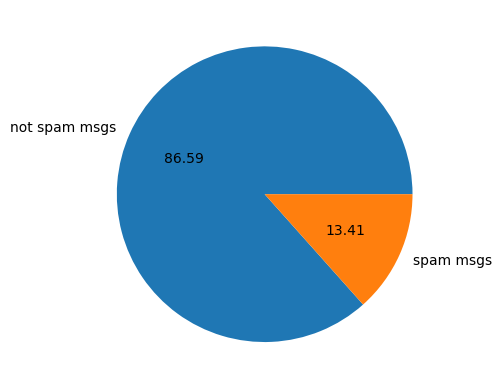

In [17]:
plt.pie(sms['spam/not spam'].value_counts() , labels= ['not spam msgs' , 'spam msgs'],autopct="%0.2f")
plt.show()

In [18]:
#now seperating data in the file

In [19]:
sms_spam = sms[sms['spam/not spam'] == 'spam']
sms_ham = sms[sms['spam/not spam']=='ham']

In [20]:
# we are going to downsample the data for trainingg as there should be no bias when training
sms_degrade = sms_ham.sample(sms_spam.shape[0])

In [21]:
print(f"Ham Shape:{sms_ham.shape} and \nSpam Shape:{sms_spam.shape}")

Ham Shape:(4825, 2) and 
Spam Shape:(747, 2)


In [22]:
sms_balanced_data = pd.concat([sms_degrade,sms_spam])
print(f"\n{sms_balanced_data.shape},\n{sms_balanced_data['spam/not spam'].value_counts()}")
#now the dataset of spam and not spam is balanced =)


(1494, 2),
spam/not spam
ham     747
spam    747
Name: count, dtype: int64


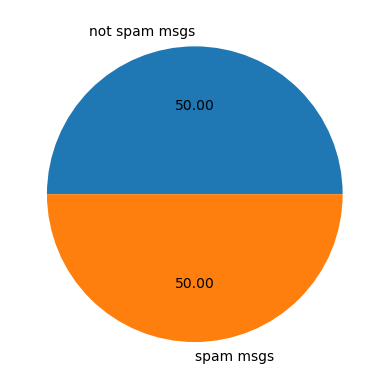

In [23]:
plt.pie(sms_balanced_data['spam/not spam'].value_counts() , labels= ['not spam msgs' , 'spam msgs'],autopct="%0.2f")
plt.show()

In [24]:
sms_balanced_data['spam']=sms_balanced_data['spam/not spam'].apply(lambda x: 1 if x=='spam' else 0)
sms_balanced_data.sample(5)

,spam/not spam,Text,spam
2256,ham,"I just lov this line: ""Hurt me with the truth,...",0
1479,ham,I think its far more than that but find out. C...,0
428,ham,Any pain on urination any thing else?,0
2229,ham,Those were my exact intentions,0
4248,spam,Text PASS to 69669 to collect your polyphonic ...,1


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sms_balanced_data['Text'],sms_balanced_data['spam'], stratify=sms_balanced_data['spam'])

In [26]:
X_train.head(4)

5547    Had your contract mobile 11 Mnths? Latest Moto...
270     Ringtone Club: Get the UK singles chart on you...
4980    Spending new years with my brother and his fam...
3873    I am joining today formally.Pls keep praying.w...
Name: Text, dtype: object

In [27]:
#check if metal platform shader is available?? ✅
if torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


In [28]:
# Bert module start here
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [29]:
# Tokenize your train and test sets directly from the 'Text' column
train_encodings = tokenizer(
    list(X_train), 
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)
test_encodings = tokenizer(
    list(X_test), 
    truncation=True,
    padding='max_length',
    return_tensors='pt'
)


In [30]:
# Convert your labels to torch tensors
train_labels = torch.tensor(y_train.values)
test_labels = torch.tensor(y_test.values)
SMSSpamDataset = sms_balanced_data  # This will shadow the class name and cause the error


In [37]:
from torch.utils.data import Dataset

class SMSSpamDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx],
        }
    
    def __len__(self):
        return len(self.labels)


In [38]:
train_dataset = SMSSpamDataset(train_encodings, train_labels)
test_dataset = SMSSpamDataset(test_encodings, test_labels)


In [39]:
#model start =)
#from transformers import AutoModelForSequenceClassification

num_labels = 2  # For binary classification: 0 (not spam), 1 (spam)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=num_labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
# some parameters about model
def count(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return {
        "Total": total_params,
        "Trainable": trainable_params,
        "Frozen": total_params - trainable_params
    }

param_count = count(model)
print("Model Parameter Counts:")
for k, v in param_count.items():
    print(f"{k}: {v:,}")


Model Parameter Counts:
Total: 109,483,778
Trainable: 109,483,778
Frozen: 0


In [41]:
# train model

In [42]:
#to evaluate the model while training
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)


In [44]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

print("MPS Available:", torch.backends.mps.is_available())  # Should print True for M4 Max


MPS Available: True


In [45]:
trainer.train()

/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.731700
20,0.695400
30,0.659100
40,0.643300
50,0.586100
60,0.511800
70,0.423200
80,0.275500
90,0.194700
100,0.142600


TrainOutput(global_step=210, training_loss=0.2636421176649275, metrics={'train_runtime': 142.6234, 'train_samples_per_second': 23.559, 'train_steps_per_second': 1.472, 'total_flos': 884053146009600.0, 'train_loss': 0.2636421176649275, 'epoch': 3.0})

In [46]:
print("\nEvaluating model...")
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")


Evaluating model...


/opt/anaconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Evaluation results: {'eval_loss': 0.10252657532691956, 'eval_runtime': 4.6452, 'eval_samples_per_second': 80.514, 'eval_steps_per_second': 1.292, 'epoch': 3.0}
